# Machine Setup Steps

## Check environment (Not actually needed for this notebook)

In [1]:
!pwd

/home/annaboser/GEOG-288KC-geospatial-foundation-models


In [2]:
import geogfm

2025-11-05 16:46:47,872 - INFO - Analysis results exported to: /home/annaboser/GEOG-288KC-geospatial-foundation-models/week1_output
2025-11-05 16:46:47,874 - INFO - Data exported - use load_week1_data() to reload


In [3]:
dir(geogfm)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'c01',
 'calculate_band_statistics',
 'calculate_ndvi',
 'create_rgb_composite',
 'create_scene_tiles',
 'export_analysis_results',
 'get_scene_info',
 'get_subset_from_scene',
 'load_sentinel2_bands',
 'load_week1_data',
 'normalize_band',
 'plot_band_comparison',
 'save_geotiff',
 'search_STAC_scenes',
 'search_sentinel2_scenes',
 'setup_planetary_computer_auth',
 'test_subset_functionality',
 'verify_environment']

In [4]:
required_packages = [
    'numpy', 'pandas', 'xarray', 'rasterio', 'rioxarray',
    'pystac_client', 'folium', 'matplotlib', 'dask'
]
env_status = geogfm.verify_environment(required_packages)


2025-11-05 16:46:47,915 - INFO - ✅ All 9 packages verified


## Check device (Optional -- you'll find out soon enough if you're on a GPU)

Make sure you have access to a GPU so model training happens in a reasonable amount of time. 

In [5]:
import numpy as np
import torch

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon MPS")
else:
    device = torch.device('cpu')
    print("Using CPU (training will be slower)")

print(f"PyTorch version: {torch.__version__}")

Using CUDA GPU: NVIDIA L40S
PyTorch version: 2.8.0+cu128


## HuggingFace Cache setup (Critical if using GeoAI Course environment)

HuggingFace by default will try to download things like model weights and datasets to the shared conda environment, which we don't individually have access to. Fix this with something like the code below: 

In [6]:
import os
import pathlib

# Specify the full path to where you want your data to be located
# Replace with your preferred location
BASE = '/home/waves/generalist_vs_specialized_geoAI'

# Setup environment variables that are used by the HF library
os.environ["HF_HOME"]            = os.path.join(BASE, "hfhome")
os.environ["HF_HUB_CACHE"]       = os.path.join(BASE, "hub")
os.environ["HF_DATASETS_CACHE"]  = os.path.join(BASE, "datasets")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(BASE, "transformers")

# Get your data into the format that TerraTorch expects

## Task specific organization

Terratorch makes your life easier if you organize your data in standard ways -- this way you can easily use their generic datamodules. 

* For classification tasks, you simply want to put each image in a different folder named by its class. This is how EuroSAT is organized. 
* For segmantation tasks, have matching images and labels (masks) have the same name followed by an identifier, for example `img_1_image.tif` and `img_1_mask.tif`. 

### Download EuroSAT

We can download EuroSAT and check that it does in fact follow this structure for a classification task. 

I downloaded it this way on the terminal: 
```{bash}
wget -c "https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1" -O /home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS.zip
```

In [7]:
from pathlib import Path

# These are just the paths that I use to store my data -- store them wherever makes sense for you. 
DATA_PATH = '/home/waves/generalist_vs_specialized_geoAI'
EUROSAT_PATH = DATA_PATH + '/EuroSAT'
EUROSAT_S2 = EUROSAT_PATH + '/EuroSAT_MS'

As you can see, at the location of the dataset, `EUROSAT_S2`, there are 10 directories each with a class name. 

In [8]:
# get the paths for each class type
class_paths = [item for item in Path(EUROSAT_S2).iterdir()]
print(class_paths)
# get the names for each class type
class_names = [p.name for p in class_paths]
print(class_names)

[PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/Pasture'), PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/Forest'), PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/SeaLake'), PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/PermanentCrop'), PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/Residential'), PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/AnnualCrop'), PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/HerbaceousVegetation'), PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/River'), PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/Industrial'), PosixPath('/home/waves/generalist_vs_specialized_geoAI/EuroSAT/EuroSAT_MS/Highway')]
['Pasture', 'Forest', 'SeaLake', 'PermanentCrop', 'Residential', 'AnnualCrop', 'HerbaceousVegetation', 'River', 'Industrial

Each folder has images of that class organized in it, just as TerraTorch expects: 

In [9]:
# You can see that each class is in fact organized in a separate folder. 
# Print the first 10 files in the first folder
pasture_ims = [item.name for item in Path(class_paths[0]).iterdir()]
print(pasture_ims[0:10])

['Pasture_665.tif', 'Pasture_1142.tif', 'Pasture_1284.tif', 'Pasture_204.tif', 'Pasture_69.tif', 'Pasture_1523.tif', 'Pasture_1951.tif', 'Pasture_1255.tif', 'Pasture_572.tif', 'Pasture_900.tif']


## Specifying splits

To make your splits easily ingestible by TerraTorch's DataModules, either make separate folders with different dataset splits in them or generate files that specify which images go in what split. 

Because EuroSAT is not already organized into separate folders by split, I went and grabbed split filesfrom torchgeo's implementation. 
I found them by looking at TorchGeo's EuroSAT datamodule implementation. 

```{python}
import urllib
for split in ["train", "val", "test"]:
    file_url = f"https://hf.co/datasets/torchgeo/eurosat/resolve/1ce6f1bfb56db63fd91b6ecc466ea67f2509774c/eurosat-{split}.txt"
    urllib.request.urlretrieve(file_url, f"{EUROSAT_PATH}/eurosat-{split}.txt")
```

## Alternative: TorchGeo download

You can download EuroSAT data using torchgeo too -- and they have a nifty subset where there's only 100 images for debugging: 

```{python}
from torchgeo.datasets import EuroSAT100

# Try without split parameter
eurosat = EuroSAT100(
    root=DATA_PATH,
    download=True,
)
```

Through exploring what was downloaded at DATA_PATH, we have:

In [125]:
EUROSAT_S2 = DATA_PATH + "/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/"

## Visualize and explore data


In [128]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [129]:
# Get the path for the first image available for each class type)
class_paths = [item for item in Path(EUROSAT_S2).iterdir()]
image_sample = [next(folder.iterdir()) for folder in class_paths]

# read all 10 sample images
ims = [rasterio.open(image).read() for image in image_sample]

# Print statistics for the first image
print("Shape:", ims[1].shape)
print("Mean:", ims[1].mean(axis=(1,2)))
print("Std:", ims[1].std(axis=(1,2)))

Shape: (13, 64, 64)
Mean: [1111.66186523  845.85400391  903.02685547  526.63574219 1144.3815918
 3190.26049805 3860.60302734 3812.14526367 1352.38745117    9.83789062
 2089.54492188  914.97509766 4252.33959961]
Std: [  8.68809973  38.35416746  92.97976963 107.77898995 109.07139847
 620.26808386 755.93244148 778.82560054 166.36251341   0.87978038
 177.60548399 107.03753341 730.85870818]


Note that the sentinel 2 data from EuroSat is L1C top of atmosphere reflectance. It's important to get this right when matching it to the right normalizations and proper model specifications

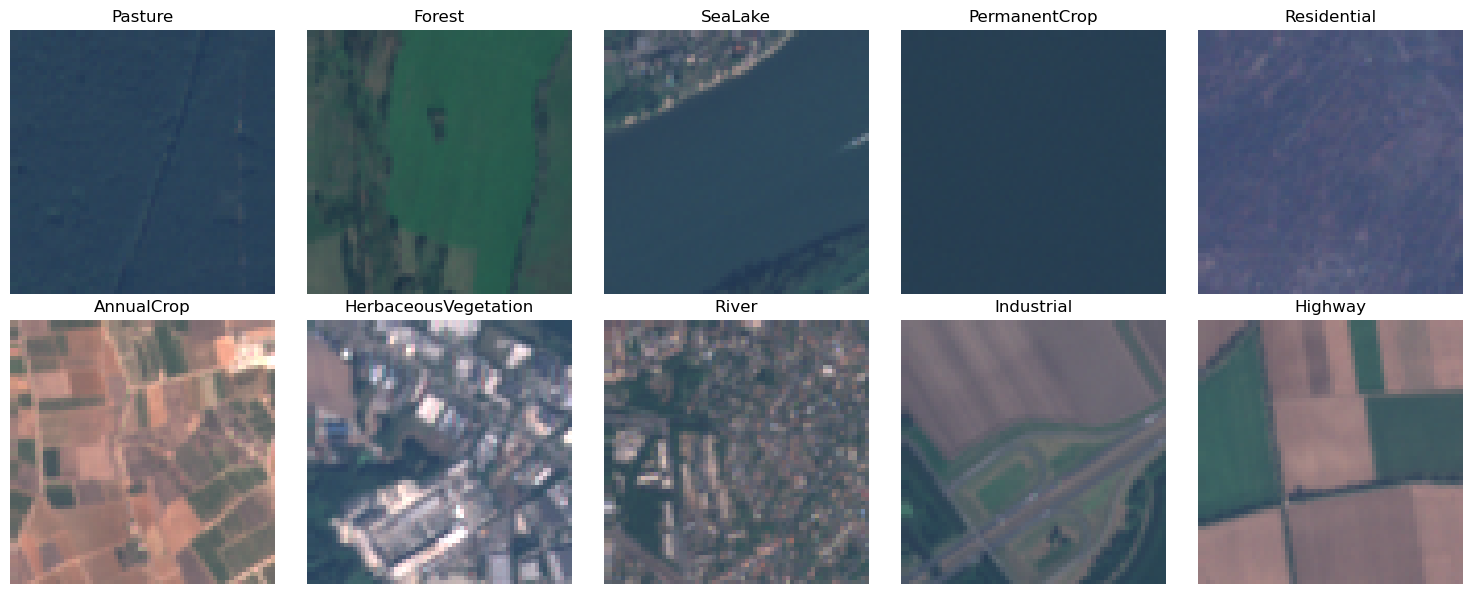

In [130]:
def to_rgb(img):
    '''
    Function to turn a rasterio raster from EuroSAT into an RGB image. 
    '''
    
    # select the red, green, and blue bands
    rgb = img[[3,2,1]].astype(float)
    
    # following EauroSAT guidelines on their github repo for visualization, 
    # clip them to a max of 2750 (there is a longer tail but very few values above this)
    # and then normalize to 0-1
    rgb = np.clip(rgb, 0, 2750) / 2750
    
    # go from bgr to rgb
    return np.transpose(rgb, (1,2,0))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, (ax, img, name) in enumerate(zip(axes, ims, class_names)):
    rgb = to_rgb(img)
    ax.imshow(rgb)
    ax.set_title(name)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Sanity check: Visualize Embeddings

## Check out all the available backbones

In [31]:
from terratorch.registry import BACKBONE_REGISTRY

print(BACKBONE_REGISTRY)

Multi source registry with 1360 items: terratorch: Registry with 92 registered items | timm: timm registry with 1268 registered backbones


In [32]:
# List all the available backbones from different sources: 
for name, source in BACKBONE_REGISTRY._sources.items():
    print(f"\n=== {name} ===")
    print(list(source))


=== terratorch ===
['dofa_small_patch16_224', 'dofa_base_patch16_224', 'dofa_large_patch16_224', 'prithvi_eo_tiny', 'prithvi_eo_v1_100', 'prithvi_eo_v2_tiny_tl', 'prithvi_eo_v2_100_tl', 'prithvi_eo_v2_300', 'prithvi_eo_v2_600', 'prithvi_eo_v2_300_tl', 'prithvi_eo_v2_600_tl', 'terramind_v1_base', 'terramind_v1_base_tim', 'terramind_v01_base', 'terramind_v01_base_tim', 'terramind_v1_large', 'terramind_v1_large_tim', 'terramind_v1_tiny', 'terramind_v1_tiny_tim', 'terramind_v1_small', 'terramind_v1_small_tim', 'terramind_v1_tokenizer_s2l2a', 'terramind_v1_tokenizer_s1rtc', 'terramind_v1_tokenizer_s1grd', 'terramind_v1_tokenizer_dem', 'terramind_v1_tokenizer_lulc', 'terramind_v1_tokenizer_ndvi', 'ssl4eol_resnet18_landsat_tm_toa_moco', 'ssl4eol_resnet18_landsat_tm_toa_simclr', 'ssl4eol_resnet18_landsat_etm_toa_moco', 'ssl4eol_resnet18_landsat_etm_toa_simclr', 'ssl4eol_resnet18_landsat_etm_sr_moco', 'ssl4eol_resnet18_landsat_etm_sr_simclr', 'ssl4eol_resnet18_landsat_oli_tirs_toa_moco', 'ssl4

In [38]:
# Find all registered Terramind backbones

print([mod for mod in list(BACKBONE_REGISTRY._sources["terratorch"]) if "terramind" in mod])

['terramind_v1_base', 'terramind_v1_base_tim', 'terramind_v01_base', 'terramind_v01_base_tim', 'terramind_v1_large', 'terramind_v1_large_tim', 'terramind_v1_tiny', 'terramind_v1_tiny_tim', 'terramind_v1_small', 'terramind_v1_small_tim', 'terramind_v1_tokenizer_s2l2a', 'terramind_v1_tokenizer_s1rtc', 'terramind_v1_tokenizer_s1grd', 'terramind_v1_tokenizer_dem', 'terramind_v1_tokenizer_lulc', 'terramind_v1_tokenizer_ndvi']


## Check out all the available decoders

In [33]:
from terratorch.registry import DECODER_REGISTRY
print(DECODER_REGISTRY)

Registered decoders:
Multi source registry with 22 items: terratorch: Registry with 11 registered items | smp: SMP registry with 11 registered backbones


In [34]:
# List all the available backbones from different sources: 
for name, source in DECODER_REGISTRY._sources.items():
    print(f"\n=== {name} ===")
    print(list(source))


=== terratorch ===
['ASPPModule', 'ASPPHead', 'ASPPSegmentationHead', 'ASPPRegressionHead', 'FCNDecoder', 'IdentityDecoder', 'LinearDecoder', 'MLPDecoder', 'SatMAEHead', 'UNetDecoder', 'UperNetDecoder']

=== smp ===
['FPN', 'PAN', 'Unet', 'MAnet', 'PSPNet', 'UnetPlusPlus', 'Segformer', 'DeepLabV3Plus', 'UPerNet', 'DeepLabV3', 'Linknet']


# Set up Terramind DataModule

You can learn all about the different inputs GenericNonGeoClassificationDataModule can take like this: 

In [136]:
from terratorch.datamodules import GenericNonGeoClassificationDataModule
?GenericNonGeoClassificationDataModule

Init signature:
GenericNonGeoClassificationDataModule(
    batch_size: int,
    num_workers: int,
    train_data_root: pathlib.Path,
    val_data_root: pathlib.Path,
    test_data_root: pathlib.Path,
    means: list[float] | str,
    stds: list[float] | str,
    num_classes: int,
    predict_data_root: pathlib.Path | None = None,
    train_split: pathlib.Path | None = None,
    val_split: pathlib.Path | None = None,
    test_split: pathlib.Path | None = None,
    ignore_split_file_extensions: bool = True,
    allow_substring_split_file: bool = True,
    dataset_bands: list[terratorch.datasets.utils.HLSBands | int] | None = None,
    predict_dataset_bands: list[terratorch.datasets.utils.HLSBands | int] | None = None,
    output_bands: list[terratorch.datasets.utils.HLSBands | int] | None = None,
    constant_scale: float = 1,
    rgb_indices: list[int] | None = None,
    train_transform: albumentations.core.composition.Compose | None | list[albumentations.core.transforms_interface.Basic

Alternatively, check out tutorials where they use them, like here: https://github.com/terrastackai/terratorch/blob/main/examples/notebooks/Tutorial_classification_timm.ipynb

Unfortunately, their use won't be exaustive, so you still have to rely on the docs to some extent. 

## Get means and standard deviations for standardization

In [132]:
# from Terramesh huggingface (https://huggingface.co/api/resolve-cache/datasets/ibm-esa-geospatial/TerraMesh/6c548cdacdd70e98a236de9f5b708d4b9dadf253/terramesh.py)
statistics = {
    "mean": {
        "S2L1C": [2357.090, 2137.398, 2018.799, 2082.998, 2295.663, 2854.548, 3122.860, 3040.571, 3306.491, 1473.849,
                  506.072, 2472.840, 1838.943],
        "S2L2A": [1390.461, 1503.332, 1718.211, 1853.926, 2199.116, 2779.989, 2987.025, 3083.248, 3132.235, 3162.989,
                  2424.902, 1857.665],
        "S2RGB": [110.349, 99.507, 75.843],
        "S1GRD": [-12.577, -20.265],
        "S1RTC": [-10.93, -17.329],
        "NDVI": [0.327],
        "DEM": [651.663],
    },
    "std": {
        "S2L1C": [1673.639, 1722.641, 1602.205, 1873.138, 1866.055, 1779.839, 1776.496, 1724.114, 1771.041, 1079.786,
                  512.404, 1340.879, 1172.435],
        "S2L2A": [2131.157, 2163.666, 2059.311, 2152.477, 2105.179, 1912.773, 1842.326, 1893.568, 1775.656, 1814.907,
                  1436.282, 1336.155],
        "S2RGB": [69.905, 53.708, 53.378],
        "S1GRD": [5.179, 5.872],
        "S1RTC": [4.391, 4.459],
        "NDVI": [0.322],
        "DEM": [928.168]
    }
}

### Band names

You need to input two sets of band names when initializing your DataModule. The first is the list of names you are giving your input bands, and the second is the list of those bands that you actually want to pass to the model, in order. In our case, both are the same, so we only specify one band name list. 

In [133]:
# Sentinel 2 band names
bands = [
    "B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12"
]

# only include expected inputs: [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>]
prithvi_bands = [
    "B2", "B3", "B4", "B8A", "B11", "B12"
]

### Transforms

Transformations are mostly useful if you want to crop your input image to fit model input dimensions(e.g. `albumentations.RandomCrop(height=224, width=224)` or `albumentations.CenterCrop(height=224, width=224)`) or do data augmentations like flip your data around (e.g. `albumentations.HorizontalFlip()` -- optional, but helpful if you have a small dataset). For augmentations, you typically only want to do them on training data so you'd want to specify different transforms for training and val/test data. 

We don't need to crop our input for TerraMind given we already have small 64x64 images and EuroSAT is already pretty big so we won't worry about augmentations right now, but we still need to transform our image to a tensor:

In [134]:
import albumentations
transforms = albumentations.pytorch.transforms.ToTensorV2() 

If you wanted to specify multiple transforms, e.g including some augmentations for training data, you could specify: 
```
transforms_train = albumentations.Compose([
    albumentations.HorizontalFlip(),
    albumentations.pytorch.transforms.ToTensorV2(),
])
```

## Define the DataModule

In [137]:
import os
from terratorch.datamodules import GenericNonGeoClassificationDataModule

datamodule = GenericNonGeoClassificationDataModule(
    batch_size=16, # How many images to train your model on at once. Larger = faster, but you could run out of memory. 
    num_workers=0, # Number of extra CPU threads to load data in parallel. More = faster but you can run into multiprocessing issues in notebooks

    # In our case, our dataset is not organized into different folders by split
    train_data_root = EUROSAT_S2,
    val_data_root = EUROSAT_S2,
    test_data_root = EUROSAT_S2,

    # Instead, we use split files
    train_split= os.path.join(EUROSAT_PATH, "eurosat-100-train.txt"), # mini version for debugging
    val_split = os.path.join(EUROSAT_PATH, "eurosat-100-val.txt"),
    test_split= os.path.join(EUROSAT_PATH, "eurosat-100-test.txt"),

    # means and standard deviations to normalize data before putting it through the model
    means=statistics['mean']['S2L1C'],
    stds=statistics['std']['S2L1C'],
    num_classes=len(class_names), # an integer -- the number of classes you're trying to predict

    # If transforms are defined with Albumentations, you can pass them here
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,

    # Bands of your dataset 
    dataset_bands=bands,
    # Bands to input into your model
    output_bands=prithvi_bands,
)

datamodule.setup("fit")

In [138]:
# Check that worked properly
batch = next(iter(datamodule.train_dataloader()))

2025-11-06 11:49:23,025 - INFO - Checking stackability.
2025-11-06 11:49:23,030 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,038 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,044 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,048 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,053 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,060 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,064 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,069 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,073 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,076 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,081 - ERROR - More samples per pixel than can be decoded: 13
2025-11-06 11:49:23,085 - ERROR - More samples per pi

# Model training

# Model/task setup

TerraTorch’s EncoderDecoderFactory makes it simple to build models. However, if you directly use `model_factory = EncoderDecoderFactory() \ model_factory.build_model(...)`, it will just give you a model with no training infrastructure. We want to be able to fine tune our model, so instead we use the Task classes because they wraps model and full Lightning training setup, making end-to-end training painless. 

In [66]:
import torch
from terratorch.tasks import ClassificationTask

task = ClassificationTask(
    model_factory="EncoderDecoderFactory",
    model_args={ 
        "backbone": "prithvi_eo_v1_100",
        "backbone_pretrained": True,            # load pretrained weights
        "decoder": "FCNDecoder",
        "num_classes": 10,
    },
    loss="ce",
    optimizer="AdamW",
    lr=1e-4,
    freeze_backbone=False
)

2025-11-05 17:51:56,153 - INFO - model_bands not passed. Assuming bands are ordered in the same way as [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>].Pretrained patch_embed layer may be misaligned with current bands


Prithvi_EO_V1_100M.pt:   0%|          | 0.00/454M [00:00<?, ?B/s]

2025-11-05 17:52:39,436 - INFO - Loaded weights for HLSBands.BLUE in position 0 of patch embed
2025-11-05 17:52:39,438 - INFO - Loaded weights for HLSBands.GREEN in position 1 of patch embed
2025-11-05 17:52:39,441 - INFO - Loaded weights for HLSBands.RED in position 2 of patch embed
2025-11-05 17:52:39,444 - INFO - Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
2025-11-05 17:52:39,445 - INFO - Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
2025-11-05 17:52:39,446 - INFO - Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
2025-11-05 17:52:39,491 - WARNING - Decoder FCNDecoder does not have an `includes_head` attribute. Falling back to the value of the registry.


## Lightning Trainer

In [80]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=20)
# logger = TensorBoardLogger(save_dir='output', name='tutorial')

# You can also log directly to WandB
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(log_model="all") 

trainer = Trainer(
    devices=1, # Number of GPUs. Interactive mode recommended with 1 device
    precision="16-mixed",
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        early_stopping_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=wandb_logger,
    max_epochs=1, # train only one epoch for demo
    default_root_dir='output/tutorial',
    log_every_n_steps=1,
    check_val_every_n_epoch=1
)

_ = trainer.fit(model=task, datamodule=datamodule)

/home/g288kc/miniforge/envs/geoAI/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/g288kc/miniforge/envs/geoAI/lib/python3.11/sit ...
INFO: Using 16bit Automatic Mixed Precision (AMP)
2025-11-05 18:29:00,147 - INFO - Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
2025-11-05 18:29:00,754 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-11-05 18:29:00,756 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-11-05 18:29:00,757 - INFO - HPU available: False, using: 0 HPUs


In [82]:
next(iter(datamodule.train_dataloader()))

MisconfigurationException: GenericNonGeoClassificationDataModule.setup must define one of ('train_dataset', 'dataset').